In [1]:
%matplotlib inline

In [2]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from __future__ import division

# Data Collection

In [5]:
data = pd.read_csv('trip_data_1.csv', skipinitialspace=True, nrows = 110000)

In [6]:
data_fare = pd.read_csv('trip_fare_1.csv',skipinitialspace = True, nrows = 110000 )

In [13]:
annual_holidays = pd.read_csv('nyc_2013_holidays.csv')

# Data Cleaning

In [14]:
data_fare['tip_percent'] = data_fare['tip_amount'] / (data_fare['fare_amount'] + data_fare['surcharge'] + data_fare['mta_tax'])

In [15]:
data_fare = data_fare.drop(data_fare[data_fare.tip_percent > 1].index)

In [16]:
data_fare.shape

(100000, 12)

In [17]:
data = data[:100000]
data_fare = data_fare[:100000]

In [18]:
(data_fare['tip_percent']).quantile(0.99)

0.29268292682926828

In [19]:
result = pd.concat([data, data_fare], axis=1)
temp_df = result

# Data Processing

In [20]:
datetime_necesary_columns = ['pickup_datetime']
datetime_column_names = ['pickup_month', 'pickup_weekday', 'pickup_day', 'pickup_time_in_mins', 'pickup_non_working_today',
                         'pickup_non_working_tomorrow']

#Check if it is a holiday in NYC.
def is_in_annual_holidays(the_day):
    return annual_holidays[(annual_holidays.Month == the_day.month) & (annual_holidays.Day == the_day.day)].shape[0]

# Calculates data related with 'pickup_datetime'.
def calculate_datetime_extra(row):
    dt = datetime.datetime.strptime(row.pickup_datetime, '%Y-%m-%d %H:%M:%S')
    pickup_month = dt.month
    pickup_weekday = dt.weekday()
    pickup_day = dt.day
    pickup_time_in_mins = (dt.hour * 60) + dt.minute
    pickup_non_working_today = int((pickup_weekday == 5) or (pickup_weekday == 6) or is_in_annual_holidays(dt))
    pickup_non_working_tomorrow = int((pickup_weekday == 4) or (pickup_weekday == 5) or
                                      is_in_annual_holidays(dt + datetime.timedelta(days=1)))
    
    return pd.Series({
        datetime_column_names[0]: pickup_month,
        datetime_column_names[1]: pickup_weekday,
        datetime_column_names[2]: pickup_day,
        datetime_column_names[3]: pickup_time_in_mins,
        datetime_column_names[4]: pickup_non_working_today,
        datetime_column_names[5]: pickup_non_working_tomorrow
    })

In [21]:
def iterate_and_apply(dataframe, function, necesary_columns):
    perform = True
    step = len(dataframe.index)
    start = 0
    to = step
    
    while perform:
        new_columns = dataframe[start:to][necesary_columns].apply(function, axis=1)
        if len(new_columns) == 0:
            perform = False
        else:
            dataframe.update(new_columns)
        new_columns = None
        start += step
        to += step
    
    return dataframe


In [22]:
for column in datetime_column_names:
    data[column] = np.nan

f_df = iterate_and_apply(data, calculate_datetime_extra, datetime_necesary_columns)

In [23]:
f_df.shape

(100000, 20)

In [24]:
for i , x in enumerate(f_df.columns):
    print i,x

0 medallion
1 hack_license
2 vendor_id
3 rate_code
4 store_and_fwd_flag
5 pickup_datetime
6 dropoff_datetime
7 passenger_count
8 trip_time_in_secs
9 trip_distance
10 pickup_longitude
11 pickup_latitude
12 dropoff_longitude
13 dropoff_latitude
14 pickup_month
15 pickup_weekday
16 pickup_day
17 pickup_time_in_mins
18 pickup_non_working_today
19 pickup_non_working_tomorrow


In [25]:
des = f_df.ix[:,14:20].copy() 

In [26]:
for i , x in enumerate(result.columns):
    print i,x

0 medallion
1 hack_license
2 vendor_id
3 rate_code
4 store_and_fwd_flag
5 pickup_datetime
6 dropoff_datetime
7 passenger_count
8 trip_time_in_secs
9 trip_distance
10 pickup_longitude
11 pickup_latitude
12 dropoff_longitude
13 dropoff_latitude
14 medallion
15 hack_license
16 vendor_id
17 pickup_datetime
18 payment_type
19 fare_amount
20 surcharge
21 mta_tax
22 tip_amount
23 tolls_amount
24 total_amount
25 tip_percent


In [27]:
des.loc[:1,'pickup_non_working_tomorrow']

0    0
1    0
Name: pickup_non_working_tomorrow, dtype: float64

In [28]:
final = pd.concat([result, des], axis=1)

In [29]:
final.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,tip_amount,tolls_amount,total_amount,tip_percent,pickup_month,pickup_weekday,pickup_day,pickup_time_in_mins,pickup_non_working_today,pickup_non_working_tomorrow
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,...,0,0,7.0,0,1,1,1,911,1,0
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.5,...,0,0,7.0,0,1,6,6,18,1,0
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.1,...,0,0,7.0,0,1,5,5,1129,1,1
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.7,...,0,0,6.0,0,1,0,7,1434,0,0
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.1,...,0,0,10.5,0,1,0,7,1405,0,0


In [30]:
set(result.columns) - set(f_df.columns)

{'fare_amount',
 'mta_tax',
 'payment_type',
 'surcharge',
 'tip_amount',
 'tip_percent',
 'tolls_amount',
 'total_amount'}

In [31]:
processed = final

In [33]:
tip_label_column_name = 'tip_label'

tip_labels = ['[0-10)', '[10-15)', '[15-20)', '[20-25)', '[25-30)', '[30-inf)']
tip_ranges_by_label = [[0, 0.10], [0.10, 0.15], [0.15, 0.20], [0.20, 0.25], [0.25, 0.30], [0.30, 1.00]]

In [34]:
processed.loc[5, ['pickup_month']]

pickup_month    1
Name: 5, dtype: object

In [35]:
columns = list(processed.columns )

In [36]:
columns[0] = 'medallion1'
columns[1] = 'hack_license1'
columns[2] = 'vendor_id1'

In [37]:
processed.columns = columns

In [38]:
for i , x in enumerate(processed.columns):
    print i,x

0 medallion1
1 hack_license1
2 vendor_id1
3 rate_code
4 store_and_fwd_flag
5 pickup_datetime
6 dropoff_datetime
7 passenger_count
8 trip_time_in_secs
9 trip_distance
10 pickup_longitude
11 pickup_latitude
12 dropoff_longitude
13 dropoff_latitude
14 medallion
15 hack_license
16 vendor_id
17 pickup_datetime
18 payment_type
19 fare_amount
20 surcharge
21 mta_tax
22 tip_amount
23 tolls_amount
24 total_amount
25 tip_percent
26 pickup_month
27 pickup_weekday
28 pickup_day
29 pickup_time_in_mins
30 pickup_non_working_today
31 pickup_non_working_tomorrow


In [39]:
processed = processed.drop(result.columns[[14,15,16]], axis=1, inplace=False)

In [40]:
processed = processed[processed.tip_percent.notnull()]
processed = processed[processed.medallion1.notnull()]

In [41]:
processed.shape

(99949, 29)

In [42]:
processed['tip_label'] = ''
def label_race (row):
    if row['tip_percent'] < 0.1 :
      return '[0-10)'
    if row['tip_percent'] < 0.15 :
      return '[10-15)'
    if row['tip_percent'] < 0.2 :
      return '[15-20)'
    if row['tip_percent'] < 0.25 :
      return '[20-25)'
    if row['tip_percent'] < 0.3 :
      return '[25-30)'
    else:
      return '[30-100)'
 

In [43]:
processed['tip_label'] = processed.apply (lambda row: label_race (row),axis=1)

In [45]:
processed.head()

,medallion1,hack_license1,vendor_id1,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,tolls_amount,total_amount,tip_percent,pickup_month,pickup_weekday,pickup_day,pickup_time_in_mins,pickup_non_working_today,pickup_non_working_tomorrow,tip_label
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,...,0,7.0,0,1,1,1,911,1,0,[0-10)
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.5,...,0,7.0,0,1,6,6,18,1,0,[0-10)
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.1,...,0,7.0,0,1,5,5,1129,1,1,[0-10)
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.7,...,0,6.0,0,1,0,7,1434,0,0,[0-10)
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.1,...,0,10.5,0,1,0,7,1405,0,0,[0-10)


In [46]:
processed

,medallion1,hack_license1,vendor_id1,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,tolls_amount,total_amount,tip_percent,pickup_month,pickup_weekday,pickup_day,pickup_time_in_mins,pickup_non_working_today,pickup_non_working_tomorrow,tip_label
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.00,...,0.0,7.00,0.000000,1,1,1,911,1,0,[0-10)
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.50,...,0.0,7.00,0.000000,1,6,6,18,1,0,[0-10)
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.10,...,0.0,7.00,0.000000,1,5,5,1129,1,1,[0-10)
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.70,...,0.0,6.00,0.000000,1,0,7,1434,0,0,[0-10)
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.10,...,0.0,10.50,0.000000,1,0,7,1405,0,0,[0-10)
5,20D9ECB2CA0767CF7A01564DF2844A3E,598CCE5B9C1918568DEE71F43CF26CD2,CMT,1,N,2013-01-07 15:27:48,2013-01-07 15:38:37,1,648,1.70,...,0.0,10.00,0.000000,1,0,7,927,0,0,[0-10)
6,496644932DF3932605C22C7926FF0FE0,513189AD756FF14FE670D10B92FAF04C,CMT,1,N,2013-01-08 11:01:15,2013-01-08 11:08:14,1,418,0.80,...,0.0,6.50,0.000000,1,1,8,661,0,0,[0-10)
7,0B57B9633A2FECD3D3B1944AFC7471CF,CCD4367B417ED6634D986F573A552A62,CMT,1,N,2013-01-07 12:39:18,2013-01-07 13:10:56,3,1898,10.70,...,4.8,39.30,0.000000,1,0,7,759,0,0,[0-10)
8,2C0E91FF20A856C891483ED63589F982,1DA2F6543A62B8ED934771661A9D2FA0,CMT,1,N,2013-01-07 18:15:47,2013-01-07 18:20:47,1,299,0.80,...,0.0,7.00,0.000000,1,0,7,1095,0,0,[0-10)
9,2D4B95E2FA7B2E85118EC5CA4570FA58,CD2F522EEE1FF5F5A8D8B679E23576B3,CMT,1,N,2013-01-07 15:33:28,2013-01-07 15:49:26,2,957,2.50,...,0.0,13.50,0.000000,1,0,7,933,0,0,[0-10)


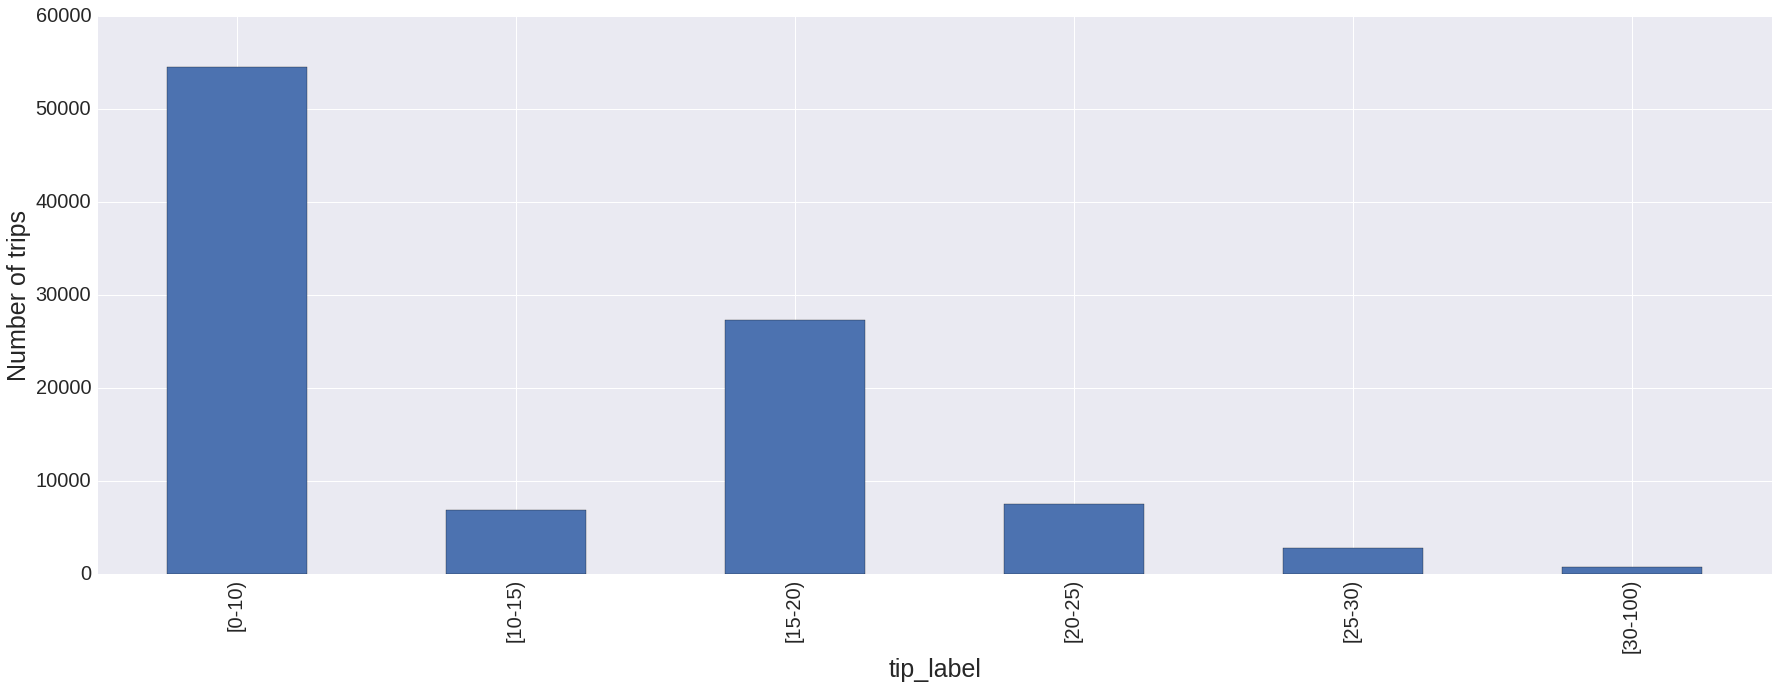

In [105]:
ax = processed.groupby('tip_label').size().plot(kind='bar', figsize=(30, 10))

ax.set_xlabel('tip_label', fontsize=25)
ax.set_ylabel('Number of trips', fontsize=25)
ax.tick_params(labelsize=20)
plt.savefig('tip_label.eps', format='eps', dpi=1000)

In [48]:
processed.shape

(99949, 30)

# Tip Prediction module using ML classifiers 

In [49]:
from matplotlib import cm as cmap

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


In [50]:
columns = list(processed.columns )
columns[0] = 'medallion'
columns[1] = 'hack_license'
columns[2] = 'vendor_id'
processed.columns = columns

In [51]:
labelize_columns = ['medallion', 'hack_license', 'vendor_id']

interize_columns = ['pickup_month', 'pickup_weekday', 'pickup_non_working_today', 'pickup_non_working_tomorrow']

feature_columns = [ 'pickup_month', 'pickup_weekday', 'pickup_day', 'surcharge',
                   'pickup_time_in_mins', 'pickup_non_working_today', 'pickup_non_working_tomorrow', 'fare_amount',
                   'passenger_count', 'trip_time_in_secs', 'trip_distance' ,'pickup_longitude',
                   'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

class_column = 'tip_label'

In [52]:
for column in labelize_columns:
    real_column = processed[column].values
    
    le = LabelEncoder()
    le.fit(real_column)
    labelized_column = le.transform(real_column)
    
    processed[column] = labelized_column
    
    le = None
    real_column = None
    labelized_column = None

In [53]:
for column in interize_columns:
    processed[column] = processed[column].astype(int)

In [54]:
data_features = processed[feature_columns].values
data_classes = processed[class_column].values

In [55]:
cross_validation = StratifiedShuffleSplit(data_classes, n_iter=10, test_size=0.1, random_state=0)

scores = []
confusion_matrices = []


# Stratified Cross Validation with Gaussian Naive Bayes

In [60]:
for train_index, test_index in cross_validation:
    data_features_train, data_classes_train = data_features[train_index], data_classes[train_index]
    data_features_test, data_classes_test = data_features[test_index], data_classes[test_index]
    clf =  GaussianNB()
    clf.fit(data_features_train, data_classes_train)
    # Saving the scores.
    test_score = clf.score(data_features_test, data_classes_test)
    scores.append(test_score)
    
    # Saving the confusion matrices.
    data_classes_pred = clf.predict(data_features_test)
    cm = confusion_matrix(data_classes_test, data_classes_pred)
    confusion_matrices.append(cm)
    
    clf = None

In [61]:
print 'Accuracy mean: ' + str(np.mean(scores))
print 'Accuracy std: ' + str(np.std(scores))

Accuracy mean: 0.451048857762
Accuracy std: 0.126915812196


# Stratified Cross Validation with Random Forest Classifier

In [56]:
for train_index, test_index in cross_validation:
    data_features_train, data_classes_train = data_features[train_index], data_classes[train_index]
    data_features_test, data_classes_test = data_features[test_index], data_classes[test_index]
    clf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
    clf.fit(data_features_train, data_classes_train)
    # Saving the scores.
    test_score = clf.score(data_features_test, data_classes_test)
    scores.append(test_score)
    
    # Saving the confusion matrices.
    data_classes_pred = clf.predict(data_features_test)
    cm = confusion_matrix(data_classes_test, data_classes_pred)
    confusion_matrices.append(cm)
    
    clf = None
    
    
    

In [57]:
print 'Accuracy mean: ' + str(np.mean(scores))
print 'Accuracy std: ' + str(np.std(scores))

Accuracy mean: 0.535927963982
Accuracy std: 0.00202793281037


# Stratified Cross Validation with Adaboost Classifier

In [74]:
for train_index, test_index in cross_validation:
    data_features_train, data_classes_train = data_features[train_index], data_classes[train_index]
    data_features_test, data_classes_test = data_features[test_index], data_classes[test_index]
    clf = AdaBoostClassifier()
    clf.fit(data_features_train, data_classes_train)
    # Saving the scores.
    test_score = clf.score(data_features_test, data_classes_test)
    scores.append(test_score)
    
    # Saving the confusion matrices.
    data_classes_pred = clf.predict(data_features_test)
    cm = confusion_matrix(data_classes_test, data_classes_pred)
    confusion_matrices.append(cm)
    
    clf = None
    
    
    

In [75]:
print 'Accuracy mean: ' + str(np.mean(scores))
print 'Accuracy std: ' + str(np.std(scores))

Accuracy mean: 0.888484242121
Accuracy std: 0.000382813936362


# AdaBoost has marginally better performance as compared to Random Forest. Visualization of Confusion Matrix for the same:

/home/aashu/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


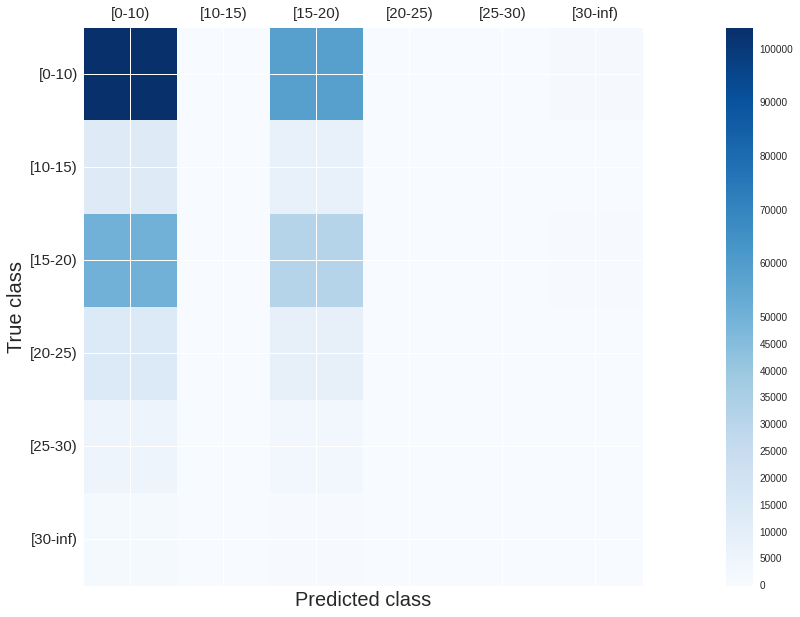

In [62]:
classes = [' ', '[0-10)', '[10-15)', '[15-20)', '[20-25)', '[25-30)', '[30-inf)']

first = True
cm = None

for cm_iter in confusion_matrices:
    if first:
        cm = cm_iter.copy()
        first = False
    else:
        cm = cm + cm_iter

fig, axes = plt.subplots(figsize=(30, 10))

colorbar = axes.matshow(cm, cmap=cmap.Blues) 
fig.colorbar(colorbar, ticks=[0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 60000, 70000, 80000, 90000, 100000])

axes.set_xlabel('Predicted class', fontsize=20)
axes.set_ylabel('True class', fontsize=20)

axes.set_xticklabels(classes)
axes.set_yticklabels(classes)

axes.tick_params(labelsize=15)
fig.savefig('confusion_matrix1.svg', format='svg', dpi=1200)

# We merge the class labels. Now this is essentially Binary Classification Task.

In [63]:
def label_tip (row):
    if row['tip_percent'] < 0.2 :
      return '[0-20)'
    else:
      return '[20-100)'

In [64]:
processed['tip_new_label'] = processed.apply(lambda row: label_tip(row),axis=1)

In [65]:
processed

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,total_amount,tip_percent,pickup_month,pickup_weekday,pickup_day,pickup_time_in_mins,pickup_non_working_today,pickup_non_working_tomorrow,tip_label,tip_new_label
0,3470,7220,0,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.00,...,7.00,0.000000,1,1,1,911,1,0,[0-10),[0-20)
1,303,6243,0,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.50,...,7.00,0.000000,1,6,6,18,1,0,[0-10),[0-20)
2,303,6243,0,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.10,...,7.00,0.000000,1,5,5,1129,1,1,[0-10),[0-20)
3,5659,3159,0,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.70,...,6.00,0.000000,1,0,7,1434,0,0,[0-10),[0-20)
4,5659,3159,0,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.10,...,10.50,0.000000,1,0,7,1405,0,0,[0-10),[0-20)
5,844,3504,0,1,N,2013-01-07 15:27:48,2013-01-07 15:38:37,1,648,1.70,...,10.00,0.000000,1,0,7,927,0,0,[0-10),[0-20)
6,1837,3130,0,1,N,2013-01-08 11:01:15,2013-01-08 11:08:14,1,418,0.80,...,6.50,0.000000,1,1,8,661,0,0,[0-10),[0-20)
7,294,7937,0,1,N,2013-01-07 12:39:18,2013-01-07 13:10:56,3,1898,10.70,...,39.30,0.000000,1,0,7,759,0,0,[0-10),[0-20)
8,1118,1120,0,1,N,2013-01-07 18:15:47,2013-01-07 18:20:47,1,299,0.80,...,7.00,0.000000,1,0,7,1095,0,0,[0-10),[0-20)
9,1140,7945,0,1,N,2013-01-07 15:33:28,2013-01-07 15:49:26,2,957,2.50,...,13.50,0.000000,1,0,7,933,0,0,[0-10),[0-20)


In [67]:
labelize_columns = ['medallion', 'hack_license', 'vendor_id']

interize_columns = ['pickup_month', 'pickup_weekday', 'pickup_non_working_today', 'pickup_non_working_tomorrow']

feature_columns = [ 'pickup_month', 'pickup_weekday', 'pickup_day', 'surcharge',
                   'pickup_time_in_mins', 'pickup_non_working_today', 'pickup_non_working_tomorrow', 'fare_amount',
                   'passenger_count', 'trip_time_in_secs', 'trip_distance' ,'pickup_longitude',
                   'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

class_column = 'tip_new_label'

In [68]:
for column in labelize_columns:
    real_column = processed[column].values
    
    le = LabelEncoder()
    le.fit(real_column)
    labelized_column = le.transform(real_column)
    
    processed[column] = labelized_column
    
    le = None
    real_column = None
    labelized_column = None

In [69]:
for column in interize_columns:
    processed[column] = processed[column].astype(int)

In [70]:
data_features = processed[feature_columns].values
data_classes = processed[class_column].values

In [71]:
cross_validation = StratifiedShuffleSplit(data_classes, n_iter=10, test_size=0.1, random_state=0)

scores = []
confusion_matrices = []


# Stratified Cross Validation with Gaussian Naive Bayes Classifier

In [80]:
for train_index, test_index in cross_validation:
    data_features_train, data_classes_train = data_features[train_index], data_classes[train_index]
    data_features_test, data_classes_test = data_features[test_index], data_classes[test_index]
    clf =    GaussianNB()
    clf.fit(data_features_train, data_classes_train)
    # Saving the scores.
    test_score = clf.score(data_features_test, data_classes_test)
    scores.append(test_score)
    
    # Saving the confusion matrices.
    data_classes_pred = clf.predict(data_features_test)
    cm = confusion_matrix(data_classes_test, data_classes_pred)
    confusion_matrices.append(cm)
    
    clf = None
    
    

In [81]:
print 'Accuracy mean: ' + str(np.mean(scores))
print 'Accuracy std: ' + str(np.std(scores))

Accuracy mean: 0.875931965983
Accuracy std: 0.0104968147347


# Stratified Cross Validation with Random Forest Classifier

In [82]:
for train_index, test_index in cross_validation:
    data_features_train, data_classes_train = data_features[train_index], data_classes[train_index]
    data_features_test, data_classes_test = data_features[test_index], data_classes[test_index]
    clf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
    clf.fit(data_features_train, data_classes_train)
    # Saving the scores.
    test_score = clf.score(data_features_test, data_classes_test)
    scores.append(test_score)
    
    # Saving the confusion matrices.
    data_classes_pred = clf.predict(data_features_test)
    cm = confusion_matrix(data_classes_test, data_classes_pred)
    confusion_matrices.append(cm)
    
    clf = None
    
    

In [83]:
print 'Accuracy mean: ' + str(np.mean(scores))
print 'Accuracy std: ' + str(np.std(scores))

Accuracy mean: 0.878015674504
Accuracy std: 0.0106563275953


# Stratified Cross Validation with Adaboost Classifier

In [132]:
for train_index, test_index in cross_validation:
    data_features_train, data_classes_train = data_features[train_index], data_classes[train_index]
    data_features_test, data_classes_test = data_features[test_index], data_classes[test_index]
    clf = AdaBoostClassifier()
    clf.fit(data_features_train, data_classes_train)
    # Saving the scores.
    test_score = clf.score(data_features_test, data_classes_test)
    scores.append(test_score)
    
    # Saving the confusion matrices.
    data_classes_pred = clf.predict(data_features_test)
    cm = confusion_matrix(data_classes_test, data_classes_pred)
    confusion_matrices.append(cm)
    
    clf = None
    
    

In [133]:
print 'Accuracy mean: ' + str(np.mean(scores))
print 'Accuracy std: ' + str(np.std(scores))

Accuracy mean: 0.888454941757
Accuracy std: 0.000408457726543


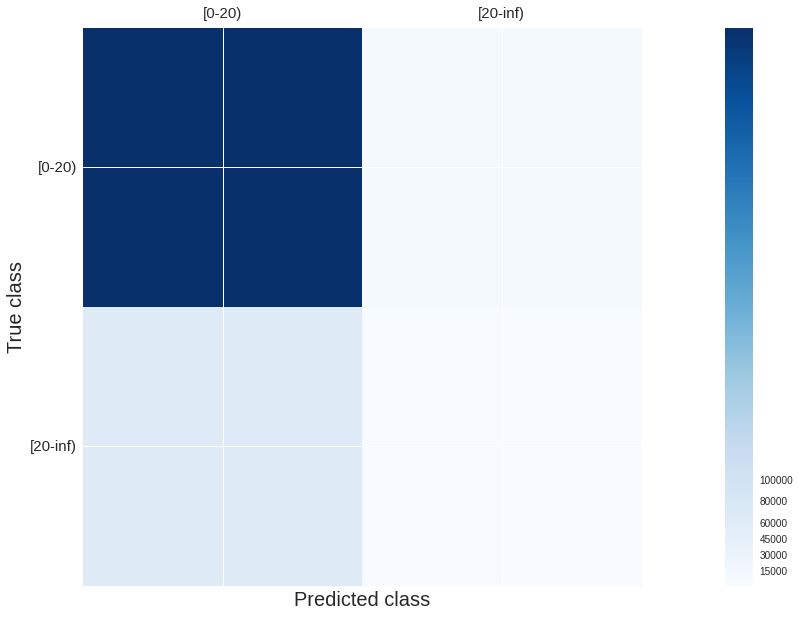

In [100]:
classes = [ '', '[0-20)', '[20-inf)']

first = True
cm = None

for cm_iter in confusion_matrices:
    if first:
        cm = cm_iter.copy()
        first = False
    else:
        cm = cm + cm_iter

fig, axes = plt.subplots(figsize=(30, 10))

colorbar = axes.matshow(cm, cmap=cmap.Blues) 
fig.colorbar(colorbar, ticks=[0,  15000,  30000, 45000,  60000,  80000, 100000])

axes.set_xlabel('Predicted class', fontsize=20)
axes.set_ylabel('True class', fontsize=20)

axes.set_xticklabels(classes)
axes.set_yticklabels(classes)

axes.tick_params(labelsize=15)
fig.savefig('confusion_matrix2.svg', format='svg', dpi=1200)

In [90]:
data.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_weekday,pickup_day,pickup_time_in_mins,pickup_non_working_today,pickup_non_working_tomorrow
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,-73.978165,40.757977,-73.989838,40.751171,1,1,1,911,1,0
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.5,-74.006683,40.731781,-73.994499,40.750660,1,6,6,18,1,0
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.1,-74.004707,40.737770,-74.009834,40.726002,1,5,5,1129,1,1
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.7,-73.974602,40.759945,-73.984734,40.759388,1,0,7,1434,0,0
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.1,-73.976250,40.748528,-74.002586,40.747868,1,0,7,1405,0,0


In [98]:
process_temp = data.copy()

In [99]:
process_temp.groupby(['pickup_longitude','pickup_latitude']).max()

,,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,dropoff_longitude,dropoff_latitude,pickup_month,pickup_weekday,pickup_day,pickup_time_in_mins,pickup_non_working_today,pickup_non_working_tomorrow
pickup_longitude,pickup_latitude,,,,,,,,,,,,,,,,,,
-98.116669,40.772568,B320B4F60F77FC79378DB0C44C5AC480,FBC33B7446C271C5B844FA9F4C234B6C,VTS,1,NaN,2013-01-13 13:08:00,2013-01-13 13:12:00,1,240,0.56,-73.989090,40.776722,1,6,13,788,1,0
-74.516670,40.727005,DFF8EEBBC5FECAAE7E75BE12C817063F,E7E95115D379C22CE30F8A1998C831CF,VTS,1,NaN,2013-01-13 12:54:00,2013-01-13 12:59:00,1,300,1.11,-73.987511,40.733208,1,6,13,774,1,0
-74.422424,40.873672,1D4E668DD639DDFDD66E96FB859DB7C3,8DE19AC7EBDC8DCD9E41D533C9AAF696,VTS,5,NaN,2013-01-13 15:49:00,2013-01-13 15:50:00,2,60,0.00,-74.422424,40.873672,1,6,13,949,1,0
-74.342957,40.447166,EB3DBCDCF0C0BEA2837D6C8C9B95EBB3,1B05CE961154B43928B595DA061D50C0,VTS,1,NaN,2013-01-13 17:11:00,2013-01-13 17:22:00,1,660,1.80,-74.342957,40.447166,1,6,13,1031,1,0
-74.267281,40.837994,BC4CB3D01850D3EC81B9D7A257D2CB18,AFB9864CAA5AF5244C65ABB20BAA4A3A,VTS,1,NaN,2013-01-13 18:44:00,2013-01-13 19:28:00,1,2640,22.22,-74.380142,40.869816,1,6,13,1124,1,0
-74.266434,40.676838,0BD94C6F9A4B2D10C99669DF9198FF8E,8236258D7B36C76FEF23BC0328F36FB0,VTS,1,NaN,2013-01-13 17:24:00,2013-01-13 17:29:00,1,300,0.91,-74.265350,40.677105,1,6,13,1044,1,0
-74.233330,40.746017,9C93E30D2CFC79A3053CB907BB93537F,2E9A9BDBC64EFCD0AFF4AAF4089979C9,VTS,1,NaN,2013-01-13 08:31:00,2013-01-13 08:35:00,1,240,0.88,-73.988495,40.748886,1,6,13,511,1,0
-74.181862,40.687717,A5179D5A72336EEDFDF90C60CAE1EA6F,A85B8B27EB885A661EF9E3E4E260EFCE,VTS,5,NaN,2013-01-13 16:31:00,2013-01-13 16:32:00,2,60,0.01,-74.181870,40.687725,1,6,13,991,1,0
-74.177979,40.690025,1E4422E1D46FF8824C0B9138B8657058,54D04D3E0B6889C0D1EC829FDE84BA46,VTS,5,NaN,2013-01-13 13:33:00,2013-01-13 13:34:00,1,60,0.00,-74.177986,40.690025,1,6,13,813,1,0
